# Домашнее задание #5: Машинное обучение и NLP

av Марат Богаутдинов, 232

### #1 $-$ EDA

Скачали датасет, анзипнули, теперь сделаем из него датафрейм:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


df = pd.read_csv('Combined Data.csv')

Посмотрим, как выглядят данные:

In [3]:
df.sample(4)

,Unnamed: 0,statement,status
10510,10510,"It all feels so dark right now, not even for l...",Suicidal
52195,52195,Significant increase in anxiety after COVID So...,Anxiety
34668,34668,Why can family members/friends never feel the ...,Anxiety
6509,6509,"SELL #BODY HEIGHT #MEDAN. HERBAL, BPOM, MUI, S...",Normal


Кажется, колонка `unnamed: 0` нам вообще не пригодится. Дропнем ее от греха подальше:

In [4]:
df = df.drop(columns=['Unnamed: 0'], axis=1)

Посмотрим на распределение объектов по классам:

In [5]:
df.groupby(['status']).nunique()

,statement
status,
Anxiety,3623
Bipolar,2501
Depression,15094
Normal,16040
Personality disorder,895
Stress,2296
Suicidal,10644


Судя по числам, как-то грустно :(( Но давайте попробуем визуализировать, может, мы просто придумываем, и на самом деле все не так уж плохо?

<Axes: title={'center': 'Class Distribution Over Dataset'}, xlabel='status'>

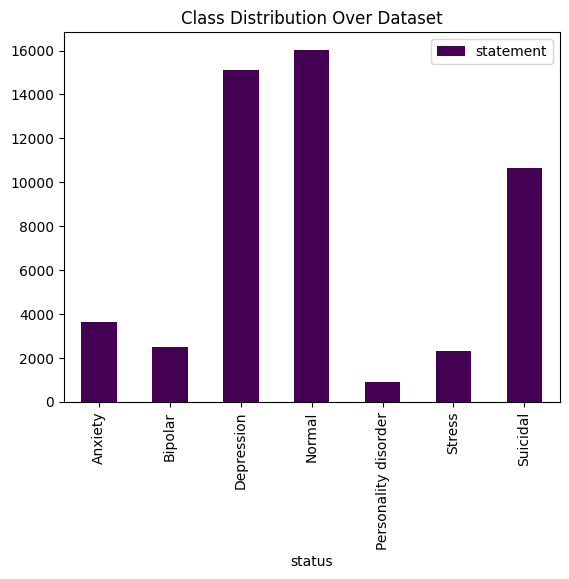

In [6]:
df.groupby(['status']).nunique().plot.bar(colormap='viridis', title='Class Distribution Over Dataset')

К сожалению, все достаточно грустно: данные распределены неравномерно. Впрочем, это и стоит всегда ожидать от реальных данных (наверное). Как мы бы могли бороться с этим? Можно было бы рандомно дропнуть какие-то данные из больших классов или нафармить (оттуда же, из твиттера) новых данных в маленькие классы... Но мы, пожалуй, просто запомним это и во время разделения на обучающую и тренировочную выборки не забудем включить параметр `stratify`, отвечающий как раз за сбалансированность классов между собой (при делении на выборки). А еще будем использовать эту информацию при объяснении результатов: я бы сразу предполагал, что маленькие классы будут предсказываться хуже (просто потому, что меньше данных).  

С другой стороны, все не прям чтоб плохо: все-таки мы имеем дело с классами около 1000 объектов (при наибольшем около 16 тысяч). То есть нам точно не нужно объединять маленькие классы в единый мусорный, и это уже радостно.  

Попробуем нарисовать облака слов для 3 крупнейших классов: `Normal`, `Depression` и `Suicidal`. (Вообще-то на такую домашку нужно ставить `trigger warning`!!! Ааа... видимо, он не показался, потому что у меня стоит `warnings.filterwarnings("ignore")`) (ツ)  

Окей, продолжаем: объединим все тексты, чтобы потом сделать по каждому облако слов:

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# препроцессинг данных
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    return [word for word in words if word.isalpha() and word not in stop_words]
    
# получаем все твиты и склеиваем их вместе
norm_text = df['statement'].where(df['status'] == 'Normal').dropna().str.cat(sep=' ')
dep_text = df['statement'].where(df['status'] == 'Depression').dropna().str.cat(sep=' ')
sui_text = df['statement'].where(df['status'] == 'Suicidal').dropna().str.cat(sep=' ')

# сам препроцессинг: теперь токенизированные
words_norm = preprocess_text(norm_text)
words_dep = preprocess_text(dep_text)
words_sui = preprocess_text(sui_text)

Я не очень понимаю, почему нам не нужно отображать слова, общие для всех трех классов? Я согласен, что нам нужно искать отличительные черты (а в нашей задаче черты $-$ это уникальные для класса слова), но зато, оставляя общие, мы можем видеть, как тексты класса `Normal` отличаются от двух остальных (и, соответственно, чем два остальных класса похожи). Плюс если мы будем убирать общие слова, то это лишит нас важной интуиции: возможно, что во всех трех классах есть одно какое-то слово, однако частота встречаемости в них совершенно разная! По-моему, это будет заметно для моделей, которые мы будем обучать потом.

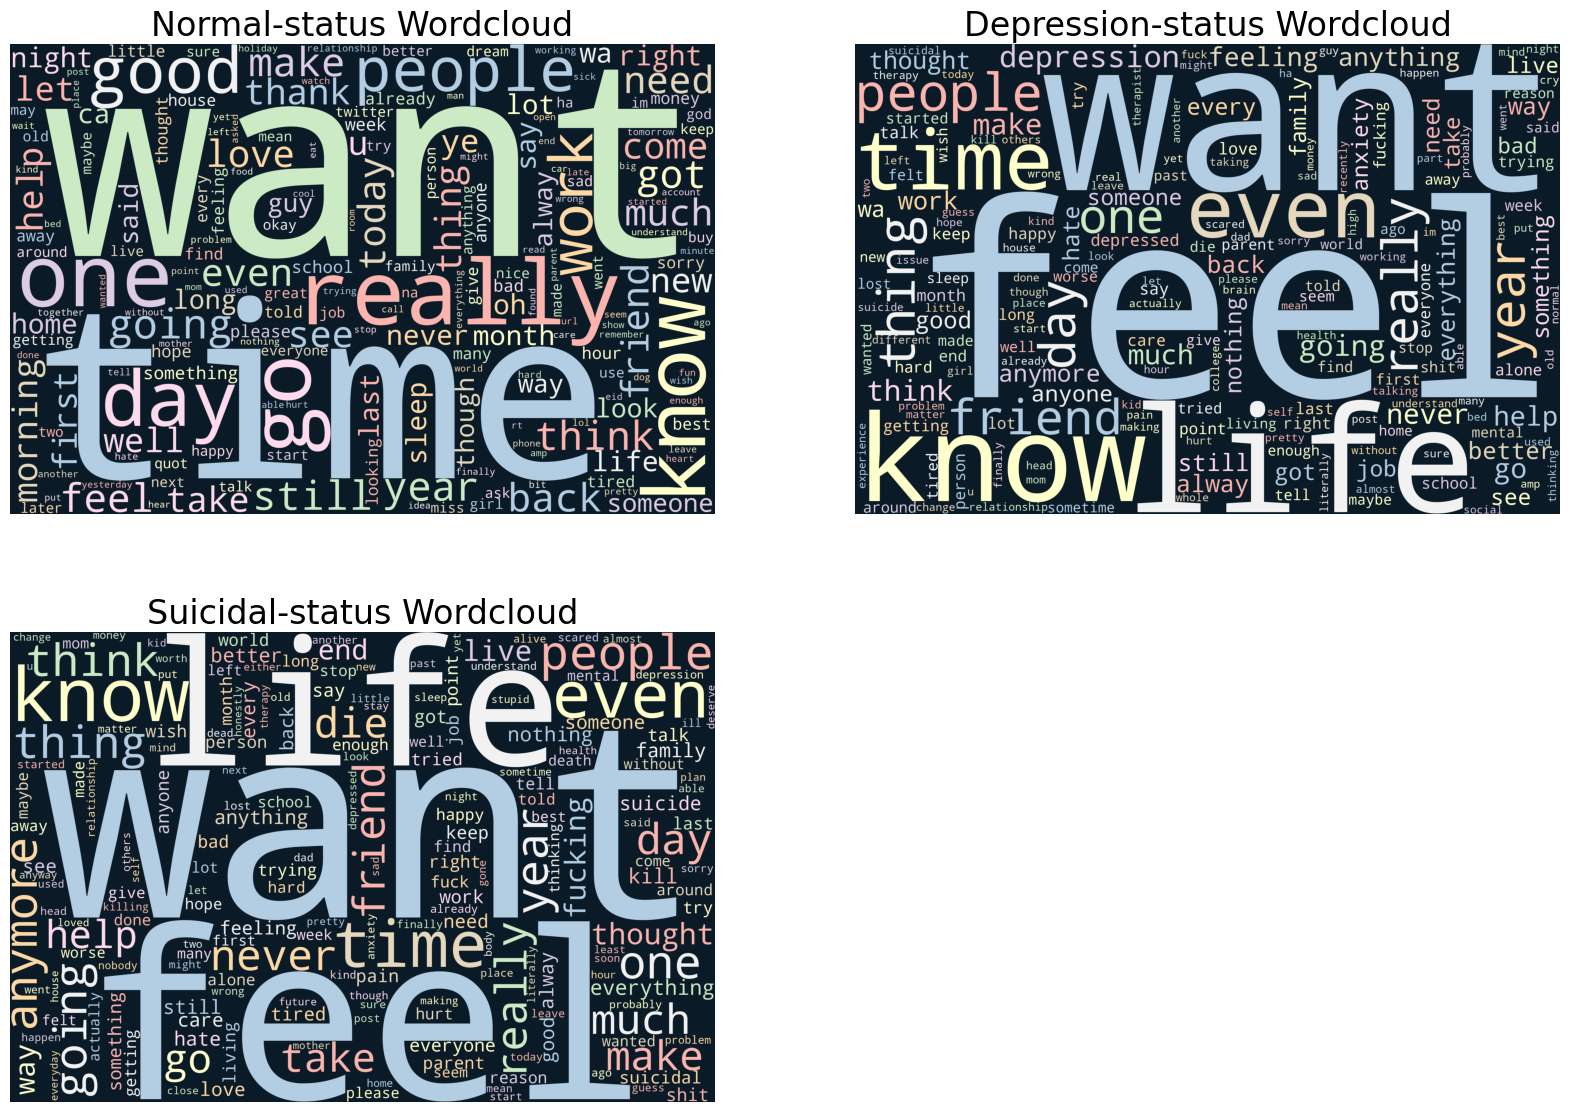

In [8]:
from wordcloud import WordCloud, STOPWORDS

def wordcloud_maker(text: str):
    wordcloud = WordCloud(
        width= 3000, 
        height = 2000, 
        random_state=108, 
        background_color='#0A1B27', 
        colormap='Pastel1', 
        collocations=False, 
        stopwords = STOPWORDS
    ).generate(' '.join(word for word in text))
    return wordcloud

fig, axes = plt.subplots(2, 2, figsize=(20, 14))

axes[0, 0].imshow(wordcloud_maker(words_norm))
axes[0, 0].set_title('Normal-status Wordcloud', fontsize=24)
axes[0, 0].axis('off')

axes[0, 1].imshow(wordcloud_maker(words_dep))
axes[0, 1].set_title('Depression-status Wordcloud', fontsize=24)
axes[0, 1].axis('off')

axes[1, 0].imshow(wordcloud_maker(words_sui))
axes[1, 0].set_title('Suicidal-status Wordcloud', fontsize=24)
axes[1, 0].axis('off')

fig.delaxes(axes[1, 1])
plt.show()

Попробуем сделать облака слов, уникальные для каждого класса. Однако уникальными мы будем считать также и те слова, которые встречались в одном из текстов чаще, чем в остальных двух:

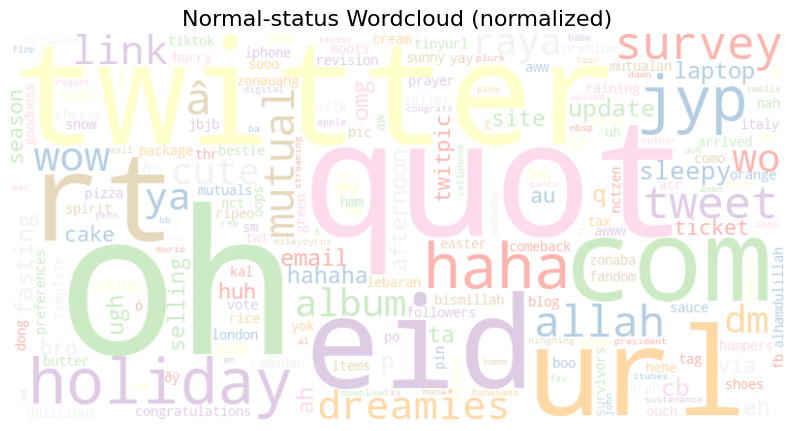

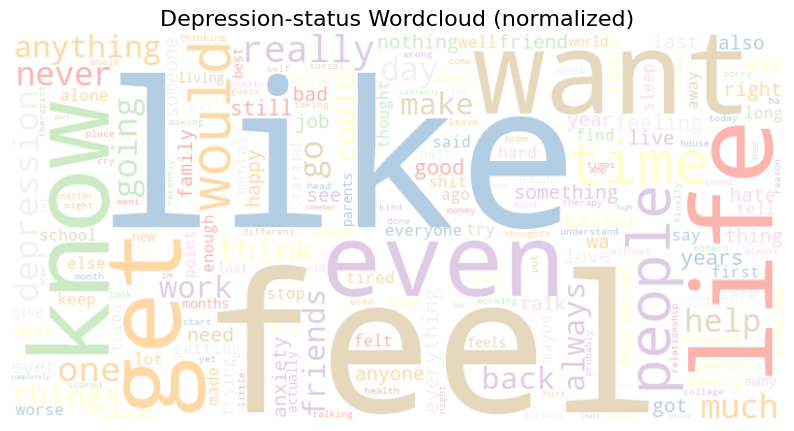

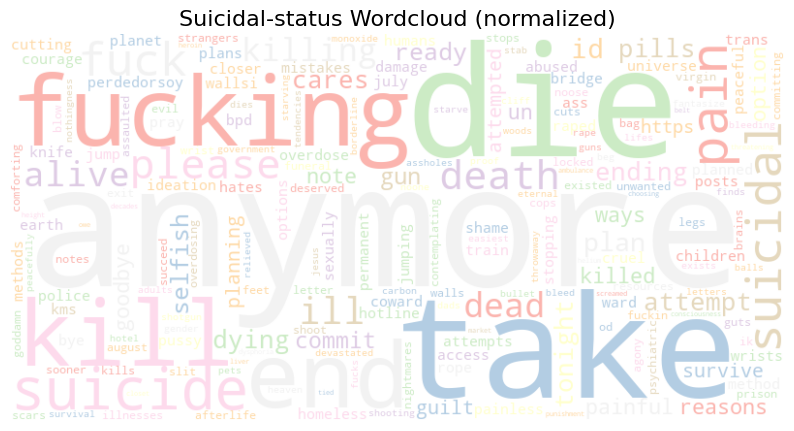

In [9]:
# считаем вхождения каждого токена
freq_norm = Counter(words_norm)
freq_dep = Counter(words_dep)
freq_sui = Counter(words_sui)

# оставляем только уникальные для каждого текста токены (уникальные по нашим правилам)
unique_norm = {word: count for word, count in freq_norm.items() if count > freq_dep[word] and count > freq_sui[word]}
unique_dep = {word: count for word, count in freq_dep.items() if count > freq_norm[word] and count > freq_sui[word]}
unique_sui = {word: count for word, count in freq_sui.items() if count > freq_norm[word] and count > freq_dep[word]}

def make_wordcloud(word_freq, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,
        colormap='Pastel1'
    ).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

make_wordcloud(unique_norm, 'Normal-status Wordcloud (normalized)')
make_wordcloud(unique_dep, 'Depression-status Wordcloud (normalized)')
make_wordcloud(unique_sui, 'Suicidal-status Wordcloud (normalized)')

Хорошо, согласен! Оставлять уникальные для класса слова дало нам некоторую интуицию. Особенно хорошо получилось с классом `Suicidal` (господи прости меня)

**Выводы по EDA:**
- объекты по классам распределены не очень хорошо $-$ будем внимательно смотреть на `confusion matrices` и помнить о дистрибуции объектов;
- некоторые частотные слова действительно хорошо репрезентируют разные классы.

### #2 $-$ предобработка данных

**1. Токенизируем, лемматизируем текстовые данные и уберем стоп-слова**

In [10]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):  
        return ''
    
    words = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words 
             if word.isalpha() and word not in stop_words]
    return ' '.join(words)

df['preprocessed'] = df['statement'].apply(preprocess_text)
df.head()

,statement,status,preprocessed
0,oh my gosh,Anxiety,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,shifted focus something else still worried
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean


**2. Делим на выборки, не забывая про параметр `stratify`**

In [11]:
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

data = df['preprocessed']
y = df['status']

data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=df['status'], random_state=102)

**3. Векторизуем текстовые данные с помощью `CountVectorizer`**

In [12]:
vectorizer = CountVectorizer()

In [13]:
X_train_cv = vectorizer.fit_transform(data_train)
X_test_cv = vectorizer.transform(data_test)

In [14]:
print(X_train_cv.shape, X_test_cv.shape)

(42434, 43612) (10609, 43612)


### #3 $-$ классификация методом логистической регрессии & векторизация CountVectorizer

**1. векторизация методом `Count` (хотя это слишком громко называть _это_ методом, tbh) и обучение модели логистической регрессии**

In [15]:
logreg = LogisticRegression(random_state=102)
logreg.fit(X_train_cv, y_train)

LogisticRegression(random_state=102)

In [16]:
pred = logreg.predict(X_test_cv)
print(classification_report(pred, y_test))

                      precision    recall  f1-score   support

             Anxiety       0.72      0.76      0.74       744
             Bipolar       0.71      0.81      0.76       502
          Depression       0.67      0.68      0.68      3038
              Normal       0.95      0.85      0.90      3652
Personality disorder       0.54      0.70      0.61       183
              Stress       0.49      0.59      0.54       445
            Suicidal       0.61      0.64      0.63      2045

            accuracy                           0.74     10609
           macro avg       0.67      0.72      0.69     10609
        weighted avg       0.75      0.74      0.74     10609



In [17]:
target_labels = np.sort(df.status.unique())

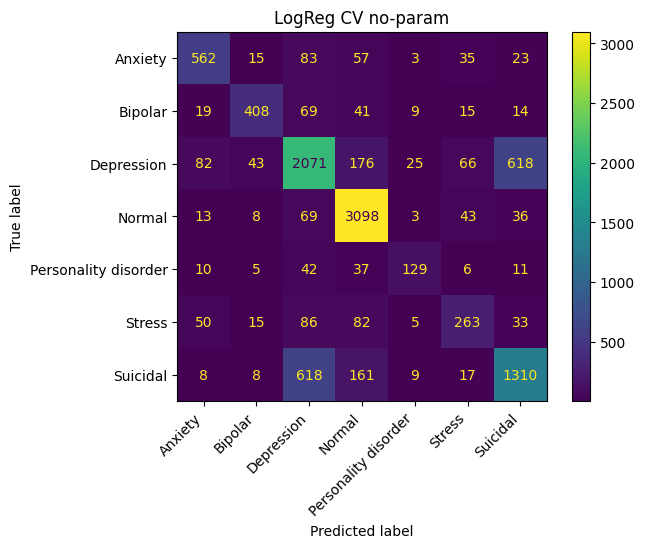

In [18]:
matrix = confusion_matrix(y_test, pred, labels=target_labels, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_labels)
disp.plot()
plt.title('LogReg CV no-param')
plt.xticks(rotation=45, ha='right')
plt.show();

**2. анализ качества модели**

Модель явно путает объекты класса `Depression` и `Suicidal`, путаются также `Depression` и `Normal`. Однако это самые многочисленные классы, поэтому неудивительно, что абсолютная величина ошибок достаточно значительная. Делаем вывод: будем нормализовывать данные. (Попробовал, получилось плохо. Пожалуй, не будем выводить ошибку в проценте.)  

Модель относительно хорошо справляется с классом `Normal` (точность 95%, полнота 85%), а хуже всего с классом `Stress` (49% точность, 59% полнота). Общий accuracy составляет 74% (однако с неравными классами это достаточно бесполезная метрика).

### #4 $-$ как работает логистическая регрессия и `CountVectorizer`

**1. как работает `CountVectorizer` (а заодно и `TfidfVectorizer`)**

Что в принципе делают векторизаторы? Составляют словарь, ключами которого являются уникальные токены, а значением $-$ вектор, характеризующий каждый токен. 
`CountVectorizer` для каждого токена считает, сколько раз он встретился в каждом отдельном документе. Эта последовательность частот и будет являться определяющим вектором.  
`TfIdfVectorizer` для каждого токена также считает его частоту встречаемости по документам, однако учитывает также важность слова (важность при сопоставлении разных документов). Величина `TF-IDF` является произведением двух: `TF` отвечает за частоту терма в конкретном документе, `IDF` подсчитывает важность терма для документа (если он встречается во многих документах, значит этот отдельный терм не такой уж и важный для идентификации, характеристики документа).

**2. как работает классификация методом логистической регрессии**

У нас есть данные, которые как-то распределены в особом (гипер)пространстве объектов. Модель же пытается провести такую гиперплоскость, которая бы лучше всего разделяла объекты в гиперпространстве. Разделив гиперпространство на зоны и соотнеся каждую из зон с определенным классом, модель предсказывает класс объекта по его координатам: в зоне какого класса оказался объект, такому класссу объект и принадлежит.


### #5 $-$ классификация методом логистической регрессии & векторизация TfidfVectorizer

**1. векторизация методом `Tf-Idf` и обучение модели логистической регрессии**

In [19]:
vectorizer = TfidfVectorizer()

In [20]:
X_train_tfidf = vectorizer.fit_transform(data_train)
X_test_tfidf = vectorizer.transform(data_test)

In [21]:
print(X_train_tfidf.shape, X_test_tfidf.shape)

(42434, 43612) (10609, 43612)


In [22]:
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=102)

In [23]:
pred = logreg.predict(X_test_tfidf)
print(classification_report(pred, y_test))

                      precision    recall  f1-score   support

             Anxiety       0.70      0.79      0.74       688
             Bipolar       0.63      0.89      0.74       403
          Depression       0.72      0.66      0.69      3360
              Normal       0.94      0.82      0.88      3759
Personality disorder       0.33      0.92      0.48        85
              Stress       0.39      0.69      0.50       301
            Suicidal       0.63      0.67      0.65      2013

            accuracy                           0.74     10609
           macro avg       0.62      0.78      0.67     10609
        weighted avg       0.76      0.74      0.75     10609



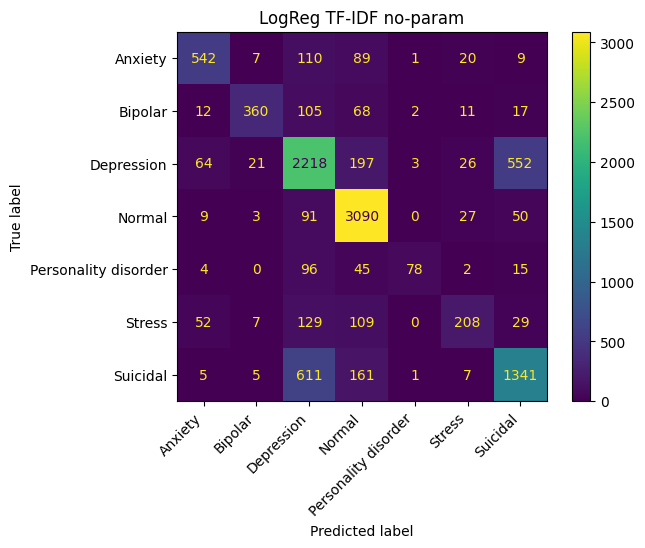

In [24]:
matrix = confusion_matrix(y_test, pred, labels=target_labels, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_labels)
disp.plot()
plt.title('LogReg TF-IDF no-param')
plt.xticks(rotation=45, ha='right')
plt.show();

**2. анализ качества модели**

Увеличилась полнота, но упала точность (если брать по `macro avg`, т.е. невзвешенные данные). Большие классы по-прежнему путаются, точность и полнота по каждому из них относительно непредсказуемо изменилась: у `Normal` и точность, и полнота немного упали, у `Depression` чуть увеличилась точность и чуть упала полнота, у `Suicidal` оба показателя подросли, а у `Stress` $-$ точность упала на 0.1, а полнота увеличилась на 0.1. В общем, в среднем accuracy остался примерно прежним (поэтому его и не очень удачно смотреть).

### #6 $-$ классификация методом решающего дерева & оба способа векторизации

**1. данные, векторизованные с помощью `CountVectorizer`**

In [47]:
clf_gini = DecisionTreeClassifier(
    criterion='gini',
    max_depth=57,
    random_state=102
    )

In [48]:
clf_gini.fit(X_train_cv, y_train)
pred = clf_gini.predict(X_test_cv)

In [49]:
print(classification_report(pred, y_test))

                      precision    recall  f1-score   support

             Anxiety       0.55      0.61      0.58       700
             Bipolar       0.51      0.60      0.55       486
          Depression       0.60      0.60      0.60      3098
              Normal       0.91      0.80      0.85      3751
Personality disorder       0.43      0.64      0.51       161
              Stress       0.33      0.43      0.37       404
            Suicidal       0.49      0.52      0.50      2009

            accuracy                           0.65     10609
           macro avg       0.54      0.60      0.57     10609
        weighted avg       0.67      0.65      0.66     10609



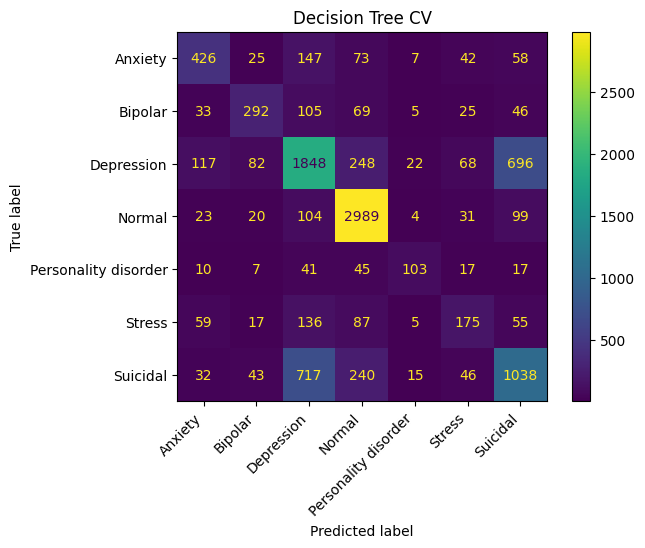

In [50]:
matrix = confusion_matrix(y_test, pred, labels=target_labels, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_labels)
disp.plot()
plt.title('Decision Tree CV')
plt.xticks(rotation=45, ha='right')
plt.show();

**2. данные, векторизованные с помощью `TfidfVectorizer`**

In [51]:
clf_gini.fit(X_train_tfidf, y_train)
pred = clf_gini.predict(X_test_tfidf)

In [52]:
print(classification_report(pred, y_test))

                      precision    recall  f1-score   support

             Anxiety       0.56      0.60      0.58       726
             Bipolar       0.52      0.59      0.55       503
          Depression       0.59      0.59      0.59      3051
              Normal       0.89      0.80      0.84      3648
Personality disorder       0.44      0.61      0.51       173
              Stress       0.34      0.41      0.37       446
            Suicidal       0.51      0.52      0.52      2062

            accuracy                           0.64     10609
           macro avg       0.55      0.59      0.57     10609
        weighted avg       0.66      0.64      0.65     10609



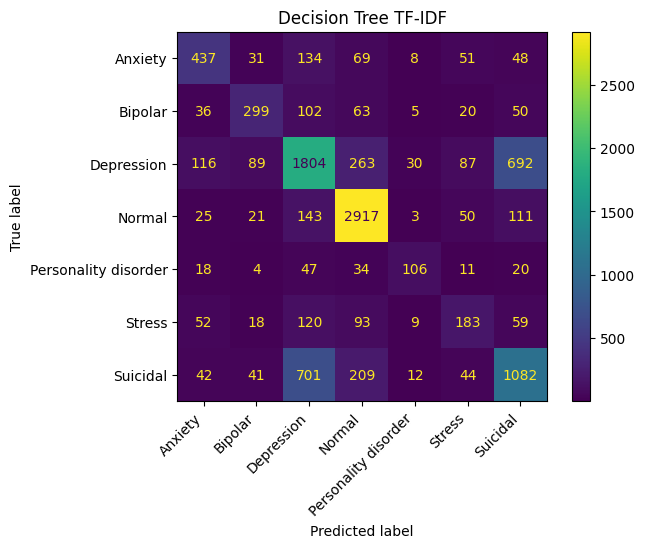

In [53]:
matrix = confusion_matrix(y_test, pred, labels=target_labels, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_labels)
disp.plot()
plt.title('Decision Tree TF-IDF')
plt.xticks(rotation=45, ha='right')
plt.show();

**3. как работает классификационная модель Decision Tree**

Модель решающего дерева работает примерно так: изначально у нее есть большая куча данных, которые нужно разделить на несколько кучек более-менее похожих друг на друга объектов. Так из большого массива данных получается несколько, которые уже меньше. Это решение о схожести данных решается одним из двух способов: критерия Джини и через информационный прирост.  
Как обычно, мы хотим добиться минимального значения функции потерь. Для этого используется величина `информативности` (или `impurity`). Критерий Джини определяет эту информативность как математическое ожидание числа ошибок, если мы будем каждый объект распределять рандомно в какой-то класс (при этом у нас есть какие-то дискретные вероятности, то есть этот рандом $-$ это перебор вероятностей).  
Классификация через информационный прирост означает минимизацию энтропии, то есть мы хотим минимизировать непредсказуемость распределения объектов по классам. Например, энтропия для случайной величины, принимающей одно значение, энтропия будет равна 0, и это интуитивно: мы точно знаем, что случайная величина не может ничем иным, кроме единственного значения, а значит непредсказуемость равна нулю. В то же время для равномерно распределенной случайной величины значение энтропии будет максимальным: мы равновероятно не знаем значение этой случайной величины.  

[Яндекс.Хендбук: Основы машинного обучения](https://education.yandex.ru/handbook/ml/article/reshayushchiye-derevya)  
[наш фикловский курс](https://hse-ling-python.github.io/) + семинарские знания оттуда

### #7 $-$ сравниваем все со всем!

**1. `Logistic Regression` или `Decision Tree`**

Явно лучше работает модель логистической регрессии: ее `accuracy` в среднем составляет 0.74, а `accuracy` решающего дерева $-$ 0.65. Это может быть связано с тем, что решающее дерево сильнее подвержено переобучению, а значит на тестовых данных эта модель ведет себя в среднем хуже.  
При этом в среднем у модели решающего дерева относительно лучше значение точность предсказания, но хуже полнота; у логистической регресии ровно наоборот.  
В обоих моделях относительно плохо предсказываются маленькие классы, а модель решающего дерева также путает `Stress` с другими более классами $-$ возможно, человек бы тоже мог путать стрессовые твиты с тревожными, нормальными и депрессивными (как мне кажется, не знаю тут).

**2. `CountVectorizer` или `TF-IDFVectorizer`**

Честно говоря, сложно сказать, какой метод векторизации оказался лучше. Я бы ожидал, что лучше бы справлялась метрика `tf-idf`, ведь она учитывает более сложные характеристики токенов. Но, кажется, это не так. Из аккуратных наблюдений могу лишь сказать, что модели, рабоютащие с токенами, векторизованными с помощью `CountVectorizer`, имеют меньшие разбросы между точностью и полнотой (везде |d| <= 0.1, d $-$ условная величина разности между значениями точности и полноты) по сравнению с данными от `TfidfVectorizer`. Возможно, это связано с тем, что мы предобработали текст: выкинули все стоп-слова, которые, по сути, и убирает метод `tf-idf`. То есть векторизаторы стали относительно похожи друг на друга (по крайней мере, больше, чем если бы тексты не были предобработаны). 

### #8 $-$ улучшаем все модели с помощью `GridSearch`

**1. `GridSearch` по подбору параметров модели логистической регрессии**

In [63]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'penalty': ['l1', 'l2', None],  # тип регуляризация
    'C':[1, 10],  # обратная сила регуляризации, ака чем меньше значение, тем больше штрафуем
    'solver': ['liblinear', 'lbfgs', 'saga'],  # алгоритм 
}

logreg = LogisticRegression(random_state=102)
clf = RandomizedSearchCV(logreg, parameters, n_iter=30, cv=5, verbose=2, n_jobs=-1);

**1.1. данные, векторизованные `CountVectorizer`**

In [64]:
%%time

clf.fit(X_train_cv, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: total: 17.6 s
Wall time: 1h 23min 55s


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=102),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'C': [1, 10],
                                        'penalty': ['l1', 'l2', None],
                                        'solver': ['liblinear', 'lbfgs',
                                                   'saga']},
                   verbose=2)

In [65]:
cv_res = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res.sort_values('rank_test_score').head().style

,params,mean_fit_time,mean_test_score,rank_test_score
0,"{'solver': 'liblinear', 'penalty': 'l1', 'C': 1}",4.617215,0.736532,1
3,"{'solver': 'liblinear', 'penalty': 'l2', 'C': 1}",40.367767,0.735613,2
4,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}",13.805521,0.731607,3
12,"{'solver': 'liblinear', 'penalty': 'l2', 'C': 10}",56.983092,0.727435,4
13,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}",11.162785,0.721308,5


In [66]:
logreg = clf.best_estimator_
pred = logreg.predict(X_test_cv)
print(classification_report(pred, y_test))

                      precision    recall  f1-score   support

             Anxiety       0.72      0.77      0.75       734
             Bipolar       0.71      0.83      0.76       490
          Depression       0.67      0.69      0.68      3001
              Normal       0.96      0.83      0.89      3763
Personality disorder       0.52      0.70      0.59       177
              Stress       0.46      0.60      0.52       407
            Suicidal       0.62      0.65      0.63      2037

            accuracy                           0.74     10609
           macro avg       0.67      0.72      0.69     10609
        weighted avg       0.76      0.74      0.75     10609



**короткий анализ**  

`accuracy` остался прежним (0.74), остальные значения изменились на 0.1..3 максимум (здесь и далее сравненение с аналогичным предсказанием, сделанным без `GridSearchCV`) 

**1.2. данные, векторизованные `TfidfVectorizer`**

In [67]:
%%time

clf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: total: 58.3 s
Wall time: 9min 39s


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=102),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'C': [1, 10],
                                        'penalty': ['l1', 'l2', None],
                                        'solver': ['liblinear', 'lbfgs',
                                                   'saga']},
                   verbose=2)

In [68]:
cv_res = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res.sort_values('rank_test_score').head().style

,params,mean_fit_time,mean_test_score,rank_test_score
2,"{'solver': 'saga', 'penalty': 'l1', 'C': 1}",58.652878,0.740279,1
12,"{'solver': 'liblinear', 'penalty': 'l2', 'C': 10}",7.715156,0.737663,2
0,"{'solver': 'liblinear', 'penalty': 'l1', 'C': 1}",2.493507,0.736933,3
13,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}",11.112714,0.734765,4
5,"{'solver': 'saga', 'penalty': 'l2', 'C': 1}",3.529407,0.733728,5


In [69]:
logreg = clf.best_estimator_
pred = logreg.predict(X_test_tfidf)
print(classification_report(pred, y_test))

                      precision    recall  f1-score   support

             Anxiety       0.73      0.78      0.75       720
             Bipolar       0.67      0.85      0.75       453
          Depression       0.72      0.68      0.70      3279
              Normal       0.94      0.83      0.88      3716
Personality disorder       0.41      0.82      0.55       121
              Stress       0.39      0.66      0.49       319
            Suicidal       0.63      0.67      0.65      2001

            accuracy                           0.74     10609
           macro avg       0.64      0.76      0.68     10609
        weighted avg       0.77      0.74      0.75     10609



**короткий анализ**  

`accuracy` не изменился $-$ 0.74 0_о

**2. `GridSearch` по подбору параметров модели решающего дерева**

In [56]:
parameters = {
    'criterion': ['gini', 'entropy'],  # критерий
    'max_depth': np.arange(43, 60, 4),  # глубина дерева
    'min_samples_split': [2, 4, 8],  # объектов в сплите
    'min_samples_leaf': [2, 3, 7]  # объектов в листе
}

d_tree = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(d_tree, parameters, cv=5, verbose=2, n_jobs=-1);

**2.1. данные, векторизованные `CountVectorizer`**

In [57]:
%%time

clf.fit(X_train_cv, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
CPU times: total: 33.8 s
Wall time: 34min 1s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([43, 47, 51, 55, 59]),
                         'min_samples_leaf': [2, 3, 7],
                         'min_samples_split': [2, 4, 8]},
             verbose=2)

In [58]:
cv_res = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res.sort_values('rank_test_score').head().style

,params,mean_fit_time,mean_test_score,rank_test_score
34,"{'criterion': 'gini', 'max_depth': np.int64(55), 'min_samples_leaf': 7, 'min_samples_split': 4}",24.943534,0.642598,1
35,"{'criterion': 'gini', 'max_depth': np.int64(55), 'min_samples_leaf': 7, 'min_samples_split': 8}",25.282881,0.642598,1
33,"{'criterion': 'gini', 'max_depth': np.int64(55), 'min_samples_leaf': 7, 'min_samples_split': 2}",24.260048,0.642598,1
26,"{'criterion': 'gini', 'max_depth': np.int64(51), 'min_samples_leaf': 7, 'min_samples_split': 8}",27.834597,0.642598,4
25,"{'criterion': 'gini', 'max_depth': np.int64(51), 'min_samples_leaf': 7, 'min_samples_split': 4}",25.685766,0.642598,4


In [59]:
the_tree = clf.best_estimator_
y_pred = the_tree.predict(X_test_cv)
print(classification_report(y_pred, y_test))

                      precision    recall  f1-score   support

             Anxiety       0.56      0.57      0.57       754
             Bipolar       0.47      0.63      0.54       431
          Depression       0.62      0.58      0.60      3300
              Normal       0.91      0.79      0.85      3743
Personality disorder       0.31      0.70      0.43       107
              Stress       0.28      0.46      0.34       323
            Suicidal       0.49      0.53      0.51      1951

            accuracy                           0.64     10609
           macro avg       0.52      0.61      0.55     10609
        weighted avg       0.67      0.64      0.65     10609



**короткий анализ**  

ого, а тут `accuracy` даже упал... с 0.65 до 0.64 (ниже постараемся все объяснить)

**2.2. данные, векторизованные `TfidfVectorizer`**

In [60]:
%%time

clf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
CPU times: total: 46.2 s
Wall time: 2h 33min 11s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([43, 47, 51, 55, 59]),
                         'min_samples_leaf': [2, 3, 7],
                         'min_samples_split': [2, 4, 8]},
             verbose=2)

In [61]:
cv_res = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res.sort_values('rank_test_score').head().style

,params,mean_fit_time,mean_test_score,rank_test_score
11,"{'criterion': 'gini', 'max_depth': np.int64(47), 'min_samples_leaf': 2, 'min_samples_split': 8}",38.667715,0.636447,1
29,"{'criterion': 'gini', 'max_depth': np.int64(55), 'min_samples_leaf': 2, 'min_samples_split': 8}",46.019327,0.635717,2
10,"{'criterion': 'gini', 'max_depth': np.int64(47), 'min_samples_leaf': 2, 'min_samples_split': 4}",39.359591,0.635528,3
9,"{'criterion': 'gini', 'max_depth': np.int64(47), 'min_samples_leaf': 2, 'min_samples_split': 2}",39.039601,0.635528,3
2,"{'criterion': 'gini', 'max_depth': np.int64(43), 'min_samples_leaf': 2, 'min_samples_split': 8}",40.412679,0.635457,5


In [62]:
the_tree = clf.best_estimator_
y_pred = the_tree.predict(X_test_tfidf)
print(classification_report(y_pred, y_test))

                      precision    recall  f1-score   support

             Anxiety       0.54      0.56      0.55       753
             Bipolar       0.51      0.55      0.53       532
          Depression       0.59      0.58      0.59      3152
              Normal       0.90      0.79      0.84      3728
Personality disorder       0.36      0.63      0.46       139
              Stress       0.31      0.41      0.36       400
            Suicidal       0.48      0.54      0.51      1905

            accuracy                           0.64     10609
           macro avg       0.53      0.58      0.55     10609
        weighted avg       0.66      0.64      0.65     10609



**короткий анализ**  

`accuracy` не изменился, 0.64

**3. Анализ качества моделей и объяснение (попытка)**

Модели почти не улучшились после применения подбора гиперпараметров через `GridSearchCV`. Возможно, это связано с тем, что изначальные гиперпараметры оказались уже подобраны достаточно хорошо (такое могло просто совпасть). В случае с моделью решающего дерева так и было (во всяком случае, гиперпараметр глубины дерева я подобрал еще при самой первой тренировке модели).  
В случае логистической регрессии можно также постараться объяснить такое слабо изменившееся качество гиперпараметрами регуляризации: они достаточно жестко регуляризировали модель, можно было бы попробовать `C` равное 0.1, 0.01 и т.д. (снизить силу регуляризации). А может быть дело в том, что разделить объекты линейной гиперплоскостью в гиперпространстве лучше уже никак нельзя (ведь логистическая регрессия как раз это и делает). Наверное, стоило бы попробовать другие способы классификации/кластеризации: метод опорных векторов или случайный лес.  
В случае с решающим деревом проблема могла возникуть с глубиной дерева: 57 $-$ это достаточно большое значение. А еще для решающего дерева в целом проблемно работать с разреженными данными (которые продуцируют векторизаторы). Вот так вот все ::::::::(